In [1]:
import os
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Set paths for train and test data
data_dir = "./data"  # Assuming "data" folder is in the same directory as the notebook
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Data transformations for VGG-16
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize for VGG16
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

In [3]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # used to be 32
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # used to be 32

# Get class names
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [4]:
# Load pretrained DenseNet-201 model
densenet201 = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)

# Freeze feature extraction layers (optional for transfer learning)
for param in densenet201.features.parameters():
    param.requires_grad = False

# Modify the classifier for your dataset
num_classes = len(class_names)
densenet201.classifier = nn.Linear(in_features=1920, out_features=num_classes)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet201 = densenet201.to(device)

print("DenseNet-201 model successfully loaded and modified.")
print(device)

DenseNet-201 model successfully loaded and modified.
cuda


In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet201.parameters(), lr=5e-4)

In [6]:
def test_model(model, get_cm_data=True):
    train_correct = 0
    train_total = 0
    
    test_correct = 0
    test_total = 0

    _train_label_true = []
    _train_label_pred = []
    
    _test_label_true = []
    _test_label_pred = []
    
    model.eval()
    
    with torch.inference_mode():
        for _inputs, _labels in train_loader:
            _inputs, _labels = _inputs.to(device), _labels.to(device)
            _outputs = model(_inputs)
            _, preds = torch.max(_outputs, 1)
            train_correct += (preds == _labels).sum().item()
            train_total += _labels.size(0)
            if get_cm_data:
                _train_label_true.append(_labels)
                _train_label_pred.append(preds)
    
        for _inputs, _labels in test_loader:
            _inputs, _labels = _inputs.to(device), _labels.to(device)
            _outputs = model(_inputs)
            _, preds = torch.max(_outputs, 1)
            test_correct += (preds == _labels).sum().item()
            test_total += _labels.size(0)
            if get_cm_data:
                _test_label_true.append(_labels)
                _test_label_pred.append(preds)
    
    _train_accuracy = (train_correct / train_total) * 100
    _test_accuracy = (test_correct / test_total) * 100
    
    return _train_accuracy, _test_accuracy, _train_label_true, _train_label_pred, _test_label_true, _test_label_pred


In [7]:
num_epochs = 30

train_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in tqdm(range(num_epochs)):
    densenet201.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = densenet201(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_accuracy, test_accuracy, train_label_true, train_label_pred, test_label_true, test_label_pred = test_model(densenet201, get_cm_data=False)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f} \n")
    
    torch.save(densenet201.state_dict(), 'model_0.pth')
    
_, _, train_label_true, train_label_pred, test_label_true, test_label_pred = test_model(densenet201, get_cm_data=True)


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/30
Training Loss: 2.1161
Training Accuracy: 44.7500
Testing Accuracy: 41.7085 



  7%|█████▌                                                                             | 2/30 [00:19<04:28,  9.59s/it]

Epoch 2/30
Training Loss: 1.7088
Training Accuracy: 61.0000
Testing Accuracy: 51.7588 



 10%|████████▎                                                                          | 3/30 [00:28<04:16,  9.49s/it]

Epoch 3/30
Training Loss: 1.5207
Training Accuracy: 61.8750
Testing Accuracy: 53.2663 



 13%|███████████                                                                        | 4/30 [00:37<04:05,  9.43s/it]

Epoch 4/30
Training Loss: 1.3847
Training Accuracy: 66.6250
Testing Accuracy: 56.7839 



 17%|█████████████▊                                                                     | 5/30 [00:47<03:56,  9.46s/it]

Epoch 5/30
Training Loss: 1.2623
Training Accuracy: 68.7500
Testing Accuracy: 57.7889 



 20%|████████████████▌                                                                  | 6/30 [00:57<03:47,  9.48s/it]

Epoch 6/30
Training Loss: 1.1944
Training Accuracy: 68.7500
Testing Accuracy: 62.3116 



 23%|███████████████████▎                                                               | 7/30 [01:06<03:38,  9.49s/it]

Epoch 7/30
Training Loss: 1.1134
Training Accuracy: 71.3750
Testing Accuracy: 62.8141 



 27%|██████████████████████▏                                                            | 8/30 [01:16<03:31,  9.63s/it]

Epoch 8/30
Training Loss: 1.0711
Training Accuracy: 74.3750
Testing Accuracy: 61.8090 



 30%|████████████████████████▉                                                          | 9/30 [01:26<03:23,  9.69s/it]

Epoch 9/30
Training Loss: 1.0227
Training Accuracy: 72.1250
Testing Accuracy: 63.3166 



 33%|███████████████████████████▎                                                      | 10/30 [01:35<03:13,  9.66s/it]

Epoch 10/30
Training Loss: 0.9902
Training Accuracy: 76.2500
Testing Accuracy: 62.8141 



 37%|██████████████████████████████                                                    | 11/30 [01:45<03:01,  9.56s/it]

Epoch 11/30
Training Loss: 0.9540
Training Accuracy: 77.1250
Testing Accuracy: 62.8141 



 40%|████████████████████████████████▊                                                 | 12/30 [01:54<02:51,  9.52s/it]

Epoch 12/30
Training Loss: 0.9067
Training Accuracy: 78.6250
Testing Accuracy: 62.3116 



 43%|███████████████████████████████████▌                                              | 13/30 [02:04<02:41,  9.51s/it]

Epoch 13/30
Training Loss: 0.8684
Training Accuracy: 78.3750
Testing Accuracy: 64.8241 



 47%|██████████████████████████████████████▎                                           | 14/30 [02:13<02:31,  9.50s/it]

Epoch 14/30
Training Loss: 0.8547
Training Accuracy: 77.6250
Testing Accuracy: 62.8141 



 50%|█████████████████████████████████████████                                         | 15/30 [02:23<02:22,  9.48s/it]

Epoch 15/30
Training Loss: 0.8409
Training Accuracy: 79.6250
Testing Accuracy: 62.8141 



 53%|███████████████████████████████████████████▋                                      | 16/30 [02:32<02:13,  9.54s/it]

Epoch 16/30
Training Loss: 0.8291
Training Accuracy: 80.6250
Testing Accuracy: 64.3216 



 57%|██████████████████████████████████████████████▍                                   | 17/30 [02:42<02:03,  9.47s/it]

Epoch 17/30
Training Loss: 0.8154
Training Accuracy: 82.2500
Testing Accuracy: 64.3216 



 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:51<01:53,  9.44s/it]

Epoch 18/30
Training Loss: 0.7847
Training Accuracy: 81.8750
Testing Accuracy: 63.8191 



 63%|███████████████████████████████████████████████████▉                              | 19/30 [03:00<01:43,  9.42s/it]

Epoch 19/30
Training Loss: 0.7380
Training Accuracy: 84.3750
Testing Accuracy: 64.8241 



 67%|██████████████████████████████████████████████████████▋                           | 20/30 [03:10<01:34,  9.42s/it]

Epoch 20/30
Training Loss: 0.7426
Training Accuracy: 85.2500
Testing Accuracy: 65.3266 



 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [03:19<01:24,  9.42s/it]

Epoch 21/30
Training Loss: 0.7382
Training Accuracy: 85.5000
Testing Accuracy: 65.8291 



 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [03:29<01:15,  9.43s/it]

Epoch 22/30
Training Loss: 0.7218
Training Accuracy: 85.3750
Testing Accuracy: 65.3266 



 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [03:38<01:06,  9.45s/it]

Epoch 23/30
Training Loss: 0.6831
Training Accuracy: 86.2500
Testing Accuracy: 67.3367 



 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [03:48<00:56,  9.49s/it]

Epoch 24/30
Training Loss: 0.6604
Training Accuracy: 87.0000
Testing Accuracy: 64.8241 



 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [03:57<00:47,  9.44s/it]

Epoch 25/30
Training Loss: 0.6615
Training Accuracy: 88.2500
Testing Accuracy: 66.8342 



 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [04:06<00:37,  9.45s/it]

Epoch 26/30
Training Loss: 0.6453
Training Accuracy: 86.7500
Testing Accuracy: 64.3216 



 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [04:16<00:28,  9.46s/it]

Epoch 27/30
Training Loss: 0.6330
Training Accuracy: 86.5000
Testing Accuracy: 65.8291 



 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [04:25<00:18,  9.44s/it]

Epoch 28/30
Training Loss: 0.6159
Training Accuracy: 88.2500
Testing Accuracy: 65.3266 



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [04:35<00:09,  9.43s/it]

Epoch 29/30
Training Loss: 0.6238
Training Accuracy: 89.0000
Testing Accuracy: 65.3266 



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:44<00:00,  9.48s/it]

Epoch 30/30
Training Loss: 0.5737
Training Accuracy: 88.1250
Testing Accuracy: 64.8241 



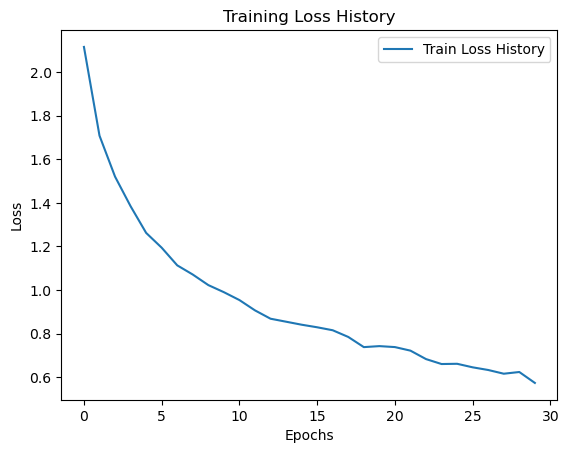

In [8]:
# Plot training loss
plt.plot(train_loss_history, label='Train Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

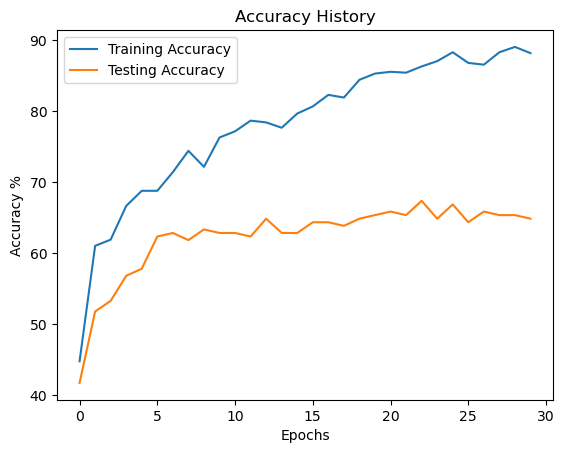

In [9]:
# Plot training loss
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.title('Accuracy History')
plt.legend()
plt.show()

In [10]:
def display_confusion_matrix(true_labels, predicted_labels, is_train=False):
    cm = confusion_matrix(torch.cat(true_labels).cpu(), torch.cat(predicted_labels).cpu(), labels=list(range(len(class_names))))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
    
    if is_train:
        plt.title("Training Confusion Matrix")
    else:
        plt.title("Testing Confusion Matrix")
        
    plt.show()

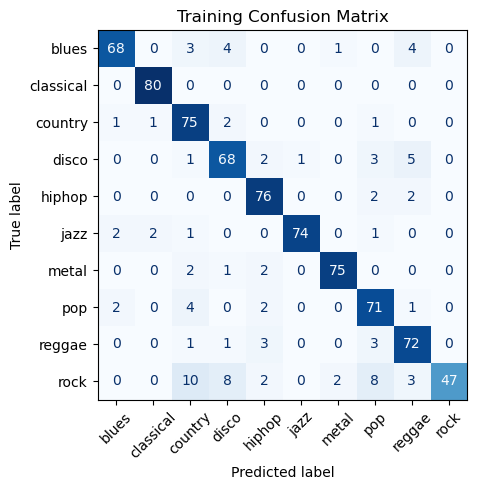

In [11]:
display_confusion_matrix(train_label_true, train_label_pred, is_train=True)

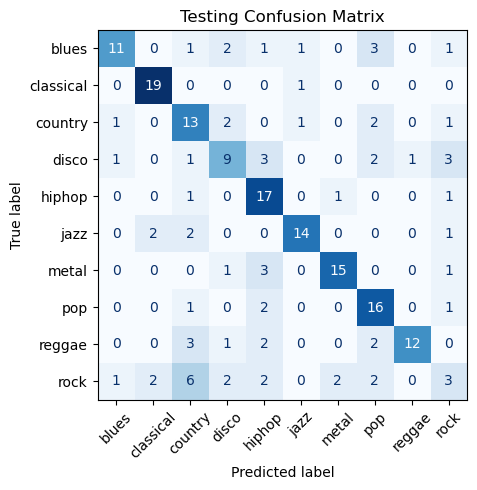

In [12]:
display_confusion_matrix(test_label_true, test_label_pred, is_train=False)